In [1]:
#importing all the libraries I will need
import urllib.request, urllib.parse, urllib.error
from bs4 import BeautifulSoup
import ssl
import requests
import csv

# Ignore SSL certificate errors
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

#User agent to get past bot filter
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}

In [2]:
#*********************
#Stage One: Finding all links

In [3]:
movie_names = []            #list for names of all movies
movie_links = []            #list for links to each movie
details_links=[]            #list for the details links for each movie

for i in range(5):                                                              #100 movie each page, we need 5 pages (#0-4)
    url = 'https://www.metacritic.com/browse/movies/score/metascore/all/filtered?sort=desc&page=' + str(i)
                                                                    #str(i) will add numbers 0-4 from range for each loop
    page = requests.get(url, headers = headers)                                                 
    soup = BeautifulSoup(page.content, "html.parser")                #looking at the html for the movie, all the information
    container = soup.find_all('td', class_ = 'clamp-summary-wrap')   #all the info we want is under td, class clamp-summary-wrap
                                                                     #so we pull that code into our container
    for movie in container:
        name = movie.find('h3').text                        #Movie titles are the only ones with heading 3, so it finds titles
        movie_names.append(name)                            #and adds them to the movie names list
        tag = movie.find('a', class_ = 'title')             #here we are searching for a, class title which contains movie links
        link = tag.get('href', None)                        #this grabs the link as a variable 
        movie_link=('https://www.metacritic.com'+ link)     #and adds to metacritic.com because it is only the end of the link
        movie_links.append(movie_link)                      #and puts it in the movie links list
        details_link=(movie_link+'/details')                #this also adds "/details" to that 
        details_links.append(details_link)                  #and puts it in the details links

print(len(details_links))    #just making sure I have all 500 movies in my links like I should

#now we have a list of all movie names and their main and details links to extract information from

500


In [4]:
#*******************************
#Stage Two: extracting information

In [5]:
def find_directors():             #defining a function to find director in a details page
    try:
        director_table = soup.find('table', class_ = 'credits', summary = movie_name + "'s Director Credits")
                                   #this finds the table director is under. These tables have a string summary with the format
                                   #"movie name's director credits"
        director_line = director_table.find_all('td', class_ = 'person')  #this finds the 'td' under the table 
                                                                          #which contains director

    except:                           #if it can't , then it will try a different format for movies which end in the letter "s"
        try:                          #but it uses the same method other than modifying the search string a bit
            director_table = soup.find('table', class_ = 'credits', summary = movie_name + "' Director Credits")
            director_line = director_table.find_all('td', class_ = 'person')
        except:                 #this except line is in case there is no director, in which case the director line will be empty
            director_line=[]
    directors = list()                         #this starts the list for directors (in case there is more than one)
    for line in director_line:                 #for each line, or search result, 
        hyperlink = line.find('a')             #this finds the hyperlink to the director's page, which is tagged with their name
        director = hyperlink.get_text()        #This grabs that name,
        directors.append(director.strip())     #strips it and adds it to directors list
    directors=tuple(directors)                 #changes the list to a tuple
    return (directors)                         #and returns the tuple as the output of the defined find_directors() function

In [6]:
def find_casts():             #defining a function to find cast in a details page. This is exactly like above
    try:                                                                                   #with a few more steps
        cast_table = soup.find('table', class_ = 'credits', summary = movie_name + "'s Cast Credits")
                                   #this finds the table cast is under. These tables have a string summary with the format
                                   #"movie name's cast credits"
        cast_line = cast_table.find_all('td', class_ = 'person')  #this finds the 'td' under the table 
                                                                          #which contains cast
    except:                       #if it can't, then it will try a different format for movies which end in the letter "s"
        try:                      
            cast_table = soup.find('table', class_ = 'credits', summary = movie_name + "' Cast Credits")
            cast_line = cast_table.find_all('td', class_ = 'person')
        except:
            cast_line=[]          #if there is no cast, line list will be empty
    try:
        p_cast_table = soup.find('table', class_ = 'credits', summary = movie_name + "'s Principal Cast Credits")
                                   #this finds the table cast is under. These tables have a string summary with the format
                                   #"movie name's principal cast credits"
        p_cast_line = p_cast_table.find_all('td', class_ = 'person')  #this finds the 'td' under the table 
                                                                          #which contains principal cast
    except:                       #if it can't, then it will try a different format for movies which end in the letter "s"
        try:                      
            p_cast_table = soup.find('table', class_ = 'credits', summary = movie_name + "' Principal Cast Credits")
            p_cast_line = p_cast_table.find_all('td', class_ = 'person')
        except:
            p_cast_line=[]          #if there is no principal cast, line list will be empty
        
    cast_line.extend(p_cast_line)       #this combines the cast and principal cast search results into one list     
    casts = list()                      #starts list of all cast
    for line in cast_line:              #for each search result from cast_line,
        hyperlink = line.find('a')      #find 'a' tag with hyperlink
        cast = hyperlink.get_text()     #take text of actors' name
        casts.append(cast.strip())      #add it to casts list
    return(casts)                       #return list of cast as output of function

In [33]:
start_csv_list=['Movie',['Director(s)'],["Cast"]]         #Start of csv list (first element) to denote category titles in file   
csv_movie_list=[]                                         #list of movies in a format fit for csv file
csv_movie_list.append(start_csv_list)                     #Adds start_csv_list as single first element in list of csv movies
all_movies=[]                                             #Start of list of all movie dictionaries 

print("Processing movies...\n")                           #Signal for me that the cell is running, because it will take time

for i in details_links:                                    #opening each details link in list to process each movie in for loop
    url=i
    page = requests.get(url, headers = headers)            #creating container for the page i detail link
    soup = BeautifulSoup(page.content, "html.parser")
    movie_name=movie_names[details_links.index(i)]         #finds movie name associated with page i by matching index, 
                                                           #and specifies movie_name variable for dictionary later in loop
        
    directors=find_directors()                             #finding director info by calling on defined find_directors function
    casts=find_casts()                                     #and cast info from defined find_casts function
    
    csv_movie=[movie_name,list(directors),casts]           #puts movie, director, cast all in a list with 3 elements
                                                           #(converting director to list from tuple)
    csv_movie_list.append(csv_movie)                       #adds the current movie's list of info as a single element
                                                           #to the list to convert to csv file later
    
    director_cast = dict()                                 #dictionary with directors/casts
    director_cast[directors] = casts                       #dictionary has directors as key and actors as value
    movie_director_dict = dict()                           #dictionary with movie as key
    movie_director_dict[movie_name] = director_cast        #director/cast dictionary as value
        
    all_movies.append(movie_director_dict)                 #adding dictionary of all movie info to list of all movie dictionaries
    
print("Done.")                                             #once all processes are done, this indicates we can move on

Processing movies...

Done.



for movie_key, movie_value in movie_dic.items():           

            for sub_key, sub_value in movie_value.items():
                directors_list=list(sub_key)
                for i in directors_list:
                    i=director
                    for i in sub_value:                                   
                        row=[movie_key,director,i]
                        csv_relationships_list.append(row)
print (csv_relationships_list)

In [34]:
#############New
csv_relationship_start_list=['Movie','Director',"Cast"]              
csv_relationships_list=[]
csv_relationships_list.append(csv_relationship_start_list)                                   

for movie_dic in all_movies:       

    for movie_key, movie_value in movie_dic.items():           

            for sub_key, sub_value in movie_value.items():
                directors_list=list(sub_key)
                for i in directors_list:
                    i=director
                    for i in sub_value:                                   
                        row=[movie_key,director,i]
                        csv_relationships_list.append(row)


In [39]:
#############New try
csv_relationship_start_list=['Movie','Director',"Cast"]              
csv_relationships_list=[]
csv_relationships_list.append(csv_relationship_start_list)                                   

for movie_dic in all_movies:       

    for movie_key, movie_value in movie_dic.items():           

            for sub_key, sub_value in movie_value.items():
                sub_key=list(sub_key)
                
                
                
                for director in sub_key:
                        for i in sub_value:                                   
                            row=[movie_key,director,i]
                            csv_relationships_list.append(row)


In [40]:
#writing csv

with open("Long form movie director actor.csv", "w", newline="") as f:         #after for loop of all 500 movies is done
                                                           #a csv file with the entire movie and info list is created
    writer = csv.writer(f)          
    writer.writerows(csv_relationships_list)                       #it writes each movie as a new row


In [42]:
import pandas as pd
df = pd.read_csv('Long form movie director actor.csv', sep=",", encoding='cp1252')
headerList = ['Movie', 'Director', 'Cast']
df.to_csv("Long form movie director actor.csv", header=headerList, index=False)
df1 = df[["Director", "Cast"]]

print (df1)

In [48]:
import networkx as nx
G = nx.Graph()
G = nx.from_pandas_edgelist(df1, 'Director', 'Cast')

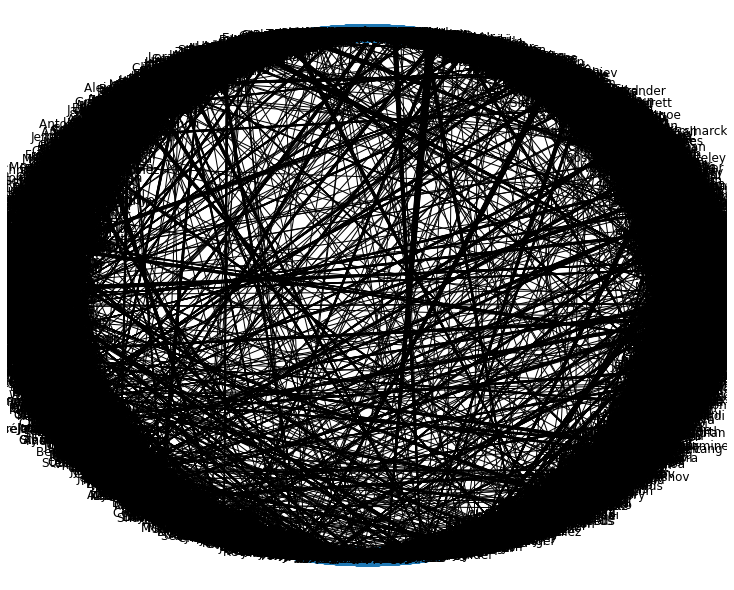

In [49]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)

In [ ]:
# I could write a program which asks people what movies or actors or directors they want to include in a visualization 
# I could make an entire list of all 500 movies available to choose from (or I could even ask about specific people)
# I can also write a query to find out how many connections a person has ##len(G['Robert De Niro'])


In [51]:
leaderboard = {}
for x in G.nodes:
 leaderboard[x] = len(G[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)

df2.head()

,connections
Alfred Hitchcock,176
Martin Scorsese,108
Paul Thomas Anderson,84
John Ford,78
Mike Leigh,75
